In [1]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pymannkendall as mk
from plotly.offline import plot
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
import hydrobr
import datetime
import tqdm as tqdm

In [2]:
warnings.simplefilter(action='ignore', category=Warning)

In [3]:
import fillinggapsts as fillinggapsts
help(fillinggapsts)

Help on module fillinggapsts:

NAME
    fillinggapsts - Created on Fri Mar 18 09:51:03 2022

DESCRIPTION
    @author: Thiago Nascimento
    Code developed for filling missing data in time-series using multiple linear regression (MLR)
    In this code we take into consideration the t-statistic value >= 2

FUNCTIONS
    fillgapslr(nonfilleddata: pandas.core.frame.DataFrame, coords: pandas.core.frame.DataFrame, filtaux=<class 'pandas.core.frame.DataFrame'>, work_w_filter=True, Use_distance=True, nummaxcorrec=50, Use_t=True)
        Function to fill the gaps of time-series (originally rainfall) based on LR (multiple or single):
            
        Inputs
        ------------------
        nonfilleddata: dataframe[n x y]: 
            Dataframe with the time-series to be filled. Gaps should be stored as np.nan, 
            each column representing one point (e.g., rain-gauges, wells), with unique codes, and the index must be set as as datetime.
        
        coords: dataframe[y x 2]: 


In [4]:
def plot_conditions(plotsome, showcodes = False):
    crs={'init':'epsg:4326'}
    geometry=[Point(xy) for xy in zip(plotsome["Longitude"], plotsome["Latitude"])]
    geodata=gpd.GeoDataFrame(plotsome,crs=crs, geometry=geometry)
    geodatacond = geodata

    # The conversiojn is needed due to the projection of the basemap:
    geodatacond = geodatacond.to_crs(epsg=3857)

    # Plot the figure and set size:
    fig, ax = plt.subplots(figsize=(15, 30))

    #Organizing the legend:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    #Ploting:
    #geodatacond.plot(ax=ax, column='PercentageGaps', legend=True, cax = cax, cmap = "Reds")
    geodatacond.plot(ax=ax, cmap = "spring")

    if showcodes == True:
        geodatacond["Code"] = geodatacond.index
        geodatacond.plot(column = 'Code',ax=ax);
        for x, y, label in zip(geodatacond.geometry.x, geodatacond.geometry.y, geodatacond.index):
            ax.annotate(label, xy=(x, y), xytext=(1, 1), textcoords="offset points")
        plt.rcParams.update({'font.size': 12})
    
    else:
        pass
    
    
    
    cx.add_basemap(ax)

In [5]:
def plotfigs(numr, numc, datatoplot, setylim = False, ymin = 0, ymax = 1):

    fig, axs = plt.subplots(int(numr),int(numc), figsize = (18, 11))

    i = 0

    for col in datatoplot.columns:
    
        plot_data = datatoplot.loc[:,col].dropna()
    
        name = col
    
        num_rows = axs.shape[0]
        num_cols = axs.shape[1]

    
        colauxs = [i for i in range(num_cols) for _ in range(num_rows)] 
        rowauxs = [*range(num_rows)] * num_cols
    
        colaux, rowaux = colauxs[i], rowauxs[i]
    
        axs[rowaux,colaux].plot(plot_data.index.values, plot_data.values, "-*", label=col, linewidth=0.5, markersize=2, color = "blue")
        axs[rowaux,colaux].set_title(name, loc='left')
        axs[rowaux,colaux].set_xlim([datetime.date(1981, 6, 1), datetime.date(2021, 12, 31)])
        
        if setylim == True:
            axs[rowaux,colaux].set_ylim(ymin, ymax)
        else:
            pass
        
        if colaux == 0:
            axs[rowaux,colaux].set_ylabel("P (mm)")
    
        i = i + 1

    plt.rcParams.update({'font.size': 8})
    plt.tight_layout()

In [7]:
path =r'C:\Users\User\OneDrive\Projects\Y2022\SPI\cooperacao_raul_e_Thiago\datasets\gauges\dailydata7.csv'
dailydata7 = pd.read_csv(path, index_col = [0])
dailydata7.index = pd.to_datetime(dailydata7.index)
dailydata7.head()

00047002  00047003  00047004  00048006  00051002  00061000  \
dates                                                                    
1981-01-01      12.1       NaN       NaN       NaN       0.5       0.0   
1981-01-02       NaN       NaN       NaN       NaN       0.0       0.0   
1981-01-03       NaN       NaN       NaN       NaN       0.2       0.0   
1981-01-04       NaN       NaN       NaN       NaN       3.3       0.0   
1981-01-05       NaN       NaN       NaN       NaN      25.0       8.3   

            00063000  00065001  00066000  00146005  ...  08168000  08250002  \
dates                                               ...                       
1981-01-01       0.0       NaN       0.0       0.0  ...      11.2      17.6   
1981-01-02       0.0       NaN       0.0       0.0  ...       0.0      22.0   
1981-01-03       0.0       NaN       0.0       0.0  ...       0.0      38.2   
1981-01-04       0.0       NaN       0.0       0.0  ...       0.0      22.4   
1981-01-05       2.2       NaN       0.0       0.0  ...       0.0       0.0   

            08261000  08351002  08359000  08360000  08360002  08361000  \
dates                                                                    
1981-01-01       0.0      14.9       NaN       0.0       0.0       0.0   
1981-01-02       0.0       0.3       NaN       0.0       0.0       0.0   
1981-01-03       0.0       7.2       NaN       0.0       0.0       0.0   
1981-01-04       0.0      28.2       NaN       0.0       0.0       0.0   
1981-01-05       0.0      12.6       NaN       0.2       0.0       0.0   

            08361001  08361004  
dates                           
1981-01-01       0.0       0.0  
1981-01-02       0.0       0.0  
1981-01-03       0.0       0.0  
1981-01-04       0.0       0.0  
1981-01-05       7.2       0.0  

[5 rows x 1898 columns]

In [8]:
path =r'C:\Users\User\OneDrive\Projects\Y2022\SPI\cooperacao_raul_e_Thiago\datasets\gauges\monthdata7.csv'
monthdata7 = pd.read_csv(path, index_col = [0])
monthdata7.index = pd.to_datetime(monthdata7.index)
monthdata7.head()

00047002  00047003  00047004  00048006  00051002  00061000  \
dates                                                                    
1981-01-31       NaN       NaN       NaN       NaN     415.1      64.4   
1981-02-28       NaN       NaN       NaN       NaN     236.1     151.2   
1981-03-31       NaN       NaN       NaN       NaN      84.3     130.7   
1981-04-30       NaN       NaN       NaN       NaN     158.7     274.1   
1981-05-31       NaN       NaN       NaN       NaN     362.8     296.3   

            00063000  00065001  00066000  00146005  ...  08168000  08250002  \
dates                                               ...                       
1981-01-31      50.8       NaN      28.8     227.2  ...     189.8     522.4   
1981-02-28     200.2       NaN     106.8     238.6  ...     217.3     625.8   
1981-03-31     129.9       NaN     158.6     187.8  ...     274.0     170.3   
1981-04-30     389.2       NaN     123.9     151.0  ...     228.6     390.3   
1981-05-31     198.0       NaN     175.2     506.9  ...     413.2     804.1   

            08261000  08351002  08359000  08360000  08360002  08361000  \
dates                                                                    
1981-01-31       6.7     266.8       NaN       1.8       0.0       3.0   
1981-02-28      58.1     575.8       NaN       NaN      11.6      24.6   
1981-03-31      44.3     222.0       NaN       4.8       0.0      74.9   
1981-04-30     302.9     343.8       NaN     286.0     231.8      84.7   
1981-05-31     437.8     444.1       NaN     323.6     371.0      66.0   

            08361001  08361004  
dates                           
1981-01-31      21.4       0.0  
1981-02-28      21.4       NaN  
1981-03-31      21.9      80.0  
1981-04-30     298.9     438.0  
1981-05-31       NaN     693.0  

[5 rows x 1898 columns]

In [9]:
path =r'C:\Users\User\OneDrive\Projects\Y2022\SPI\cooperacao_raul_e_Thiago\datasets\gauges\annualdata7.csv'
annualdata7 = pd.read_csv(path, index_col = [0])
annualdata7.index = pd.to_datetime(annualdata7.index)
annualdata7.head()

00047002  00047003  00047004  00048006  00051002  00061000  \
dates                                                                    
1981-12-31       NaN       NaN       NaN       NaN    1941.5    1784.5   
1982-12-31    2578.7    2944.2       NaN       NaN    2564.7    2465.9   
1983-12-31    1315.6    2989.0    1296.7    1597.0    2027.4    2378.3   
1984-12-31    3216.3    6861.0    2938.2    2899.4    2414.7    2246.8   
1985-12-31    3902.5       NaN    4224.8    3836.4    2777.6    1783.6   

            00063000  00065001  00066000  00146005  ...  08168000  08250002  \
dates                                               ...                       
1981-12-31    1894.4       NaN    1450.7       NaN  ...    3123.0    3814.9   
1982-12-31    1963.4       NaN    1760.0       NaN  ...    3164.7    3860.2   
1983-12-31    2034.9    2012.6       NaN    1608.7  ...    2984.2    2569.6   
1984-12-31    2367.4    2957.0    1796.1    2568.2  ...    3650.3    4697.5   
1985-12-31    1811.7    2540.7    1913.9    3046.1  ...    3190.6    4074.7   

            08261000  08351002  08359000  08360000  08360002  08361000  \
dates                                                                    
1981-12-31    2304.2    2990.9       NaN       NaN       NaN     448.8   
1982-12-31    1962.2    3412.2       NaN       NaN       NaN    1700.3   
1983-12-31    1848.3    2370.2       NaN    1058.6     936.1       NaN   
1984-12-31    1954.7    3243.1       NaN    1897.0       NaN       NaN   
1985-12-31    1635.2    2954.5    1611.4    1547.5    1112.1    1997.6   

            08361001  08361004  
dates                           
1981-12-31       NaN       NaN  
1982-12-31    1536.3    1580.8  
1983-12-31       NaN     822.1  
1984-12-31    1872.3    1110.2  
1985-12-31    1617.2       NaN  

[5 rows x 1898 columns]

In [11]:
path =r'C:\Users\User\OneDrive\Projects\Y2022\SPI\cooperacao_raul_e_Thiago\datasets\gauges\stationsused.csv'
stationsused = pd.read_csv(path, index_col = [0])
stationsused.index = annualdata7.columns
stationsused.index.name = 'Code'
stationsused

Longitude  Latitude    State         City               Name
Code                                                                  
00047002   -47.3536   -0.6231     PARÁ  SALINÓPOLIS        SALINÓPOLIS
00047003   -47.8536   -0.7375     PARÁ       CURUÇA             CURUÇA
00047004   -47.0994   -0.9294     PARÁ    PRIMAVERA          PRIMAVERA
00048006   -48.1103   -0.8681     PARÁ        VIGIA              VIGIA
00051002   -51.4203   -0.3992    AMAPÁ      MAZAGÃO              NAVIO
...             ...       ...      ...          ...                ...
08360000   -60.5289    4.1667  RORAIMA    PACARAIMA   MALOCA DO CONTÃO
08360002   -60.5711    3.2078  RORAIMA    BOA VISTA   FAZENDA PASSARÃO
08361000   -61.3839    3.6608  RORAIMA      AMAJARI   FAZENDA SÃO JOÃO
08361001   -61.2881    3.2906  RORAIMA  ALTO ALEGRE          BOQUEIRÃO
08361004   -61.0883    3.2872  RORAIMA  ALTO ALEGRE  COLÔNIA DO TAIANO

[1898 rows x 5 columns]

In [37]:
path =r'C:\Users\User\OneDrive\Projects\Y2022\SPI\cooperacao_raul_e_Thiago\stationsinfos.xlsx'
stationsinfos = pd.read_excel(path, usecols = [1,2,5,6,8,9], index_col = 1)

In [40]:
stationsall = pd.DataFrame(index = dailydata7.columns.astype(int), columns = ["Longitude", "Latitude", "State", "City", "Name"])
stationsall["Latitude"], stationsall["Longitude"], stationsall["State"], stationsall["City"], stationsall["Name"] = stationsinfos["Latitude"], stationsinfos["Longitude"], stationsinfos["State"], stationsinfos["City"], stationsinfos["Name"]
stationsall["Code"] = dailydata7.columns
stationsall.reset_index(drop=True)
stationsall.set_index(['Code'], inplace = True)
stationsall

Longitude  Latitude    State         City               Name
Code                                                                  
00047002   -47.3536   -0.6231     PARÁ  SALINÓPOLIS        SALINÓPOLIS
00047003   -47.8536   -0.7375     PARÁ       CURUÇA             CURUÇA
00047004   -47.0994   -0.9294     PARÁ    PRIMAVERA          PRIMAVERA
00048006   -48.1103   -0.8681     PARÁ        VIGIA              VIGIA
00051002   -51.4203   -0.3992    AMAPÁ      MAZAGÃO              NAVIO
...             ...       ...      ...          ...                ...
08360000   -60.5289    4.1667  RORAIMA    PACARAIMA   MALOCA DO CONTÃO
08360002   -60.5711    3.2078  RORAIMA    BOA VISTA   FAZENDA PASSARÃO
08361000   -61.3839    3.6608  RORAIMA      AMAJARI   FAZENDA SÃO JOÃO
08361001   -61.2881    3.2906  RORAIMA  ALTO ALEGRE          BOQUEIRÃO
08361004   -61.0883    3.2872  RORAIMA  ALTO ALEGRE  COLÔNIA DO TAIANO

[1898 rows x 5 columns]

In [12]:
aux = stationsused.reset_index()
filtaux = pd.DataFrame(data = aux["Code"])
filtaux

Code
0     00047002
1     00047003
2     00047004
3     00048006
4     00051002
...        ...
1893  08360000
1894  08360002
1895  08361000
1896  08361001
1897  08361004

[1898 rows x 1 columns]

In [13]:
indices = stationsused[stationsused.State == "PARAÍBA"].index

filtaux2 = filtaux.copy()
filtaux2.set_index("Code", inplace = True)
filtaux2 = filtaux2.loc[indices.tolist(),:]
filtaux2.reset_index(inplace = True)
filtaux2

Code
0   00638032
1   00734006
2   00734008
3   00735009
4   00735036
5   00735124
6   00736000
7   00736013
8   00736017
9   00736021
10  00736022
11  00737006
12  00737022
13  00836000

In [15]:
filleddata, r2listdf  = fillinggapsts.fillgapslr(monthdata7, stationsused, filtaux, work_w_filter = True, Use_t = True
                                                 , nummaxcorrec = 30)

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:03<00:00, 18.02it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.90it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 16.00it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 19.02it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 17.91it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.29it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 15.70it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.20it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.82it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 19.51it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.86it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 18.50it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.35it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 18.10it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 19.60it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.34it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.64it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.06it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 17.31it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.20it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.69it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 14.60it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.32it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 18.06it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.17it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 16.31it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 20.66it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.79it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 19.85it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 21.50it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:02<00:00, 20.18it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [00:04<00:00, 19.60it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 13.23it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 19.23it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.76it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 18.28it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 18.18it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 13.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.68it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:02<00:00, 15.18it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:02<00:00, 18.32it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 16.51it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.23it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 17.17it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 19.52it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 18.28it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.82it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 16.60it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 16.63it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:03<00:00, 19.09it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 19.17it/s]


In [16]:
filleddata.isnull().values.any()

True

In [24]:
filleddata.describe().loc["count", :].tail(50)

03056004    492.0
03056006    492.0
03057002    492.0
03151002    492.0
03151003    492.0
03152002    492.0
03152003    492.0
03152005    492.0
03152008    492.0
03152011    492.0
03152013    492.0
03152016    492.0
03153003    492.0
03153004    492.0
03153006    492.0
03153007    492.0
03153008    492.0
03153017    492.0
03153021    492.0
03154003    492.0
03155001    492.0
03252005    492.0
03252006    491.0
03252008    491.0
03253001    492.0
03253003    491.0
03253004    492.0
08051002    492.0
08051010    492.0
08052000    492.0
08062000    492.0
08067001    492.0
08067002    492.0
08068000    492.0
08069003    465.0
08150000    492.0
08160001    492.0
08161001    492.0
08166000    488.0
08167000    492.0
08168000    492.0
08250002    492.0
08261000    492.0
08351002    492.0
08359000    492.0
08360000    492.0
08360002    491.0
08361000    492.0
08361001    492.0
08361004    492.0
Name: count, dtype: float64

<AxesSubplot:>

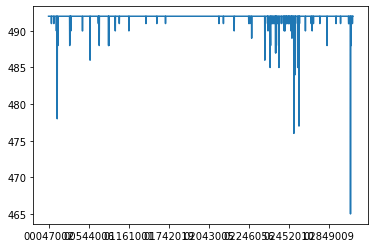

In [23]:
filleddata.describe().loc["count", :].plot()

In [25]:
np.count_nonzero(filleddata.isnull().values)

258

Now we can check the R² summary:

In [26]:
r2listdf

Mean       Min       Max
00047002  0.880877  0.855198  0.903993
00047003  0.605578  0.559009  0.637138
00047004  0.862975  0.826236  0.886021
00048006  0.832850  0.770125  0.862002
00051002  0.602416  0.379846  0.699215
...            ...       ...       ...
08360000  0.527469  0.014269  0.661676
08360002  0.678631  0.070095  0.739260
08361000  0.712870  0.657562  0.783710
08361001  0.826307  0.799589  0.833790
08361004  0.850361  0.833307  0.865852

[1898 rows x 3 columns]

Here we can check for the R plot:

<AxesSubplot:>

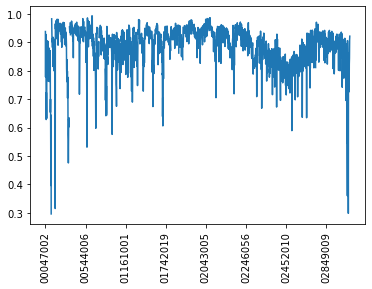

In [27]:
(r2listdf.Mean**(1/2)).plot(rot=90)

In [28]:
print("The total of gauges with R2 above 0.8 is:", len(r2listdf.T.loc[:, r2listdf.T.gt(0.8).any()].columns.to_list()), ",which is:", (len(r2listdf.T.loc[:, r2listdf.T.gt(0.8).any()].columns.to_list())/len(r2listdf))*100, "%")

The total of gauges with R2 above 0.8 is: 1514 ,which is: 79.768177028451 %


In [29]:
len(r2listdf.T.loc[:, r2listdf.T.gt(0.95).any()].columns.to_list())

38

Those are the gauges with R² above 0.95:

In [41]:
stationsall.loc[r2listdf.T.loc[:, r2listdf.T.gt(0.95).any()].columns.to_list()]

Longitude  Latitude         State                 City  \
Code                                                               
00240009   -40.2167   -2.8167         CEARÁ               ACARAÚ   
00338009   -38.6833   -3.7500         CEARÁ              CAUCAIA   
00339028   -39.2417   -3.6739         CEARÁ     SÃO LUÍS DO CURU   
00339078   -39.2667   -3.6667         CEARÁ     SÃO LUÍS DO CURU   
00438095   -38.7300   -4.2200         CEARÁ             REDENÇÃO   
00443007   -43.9311   -4.4644      MARANHÃO                 CODÓ   
00539037   -39.3681   -5.5800         CEARÁ       SENADOR POMPEU   
00638007   -38.9606   -6.7628         CEARÁ  LAVRAS DA MANGABEIR   
00638014   -38.8636   -6.4089         CEARÁ                  ICÓ   
00640003   -40.1589   -6.3264         CEARÁ             ARNEIROZ   
00640042   -40.1500   -6.3167         CEARÁ             ARNEIROZ   
01444000   -44.4603  -14.3136  MINAS GERAIS          MONTALVÂNIA   
01444001   -44.4817  -14.4311  MINAS GERAIS          MONTALVÂNIA   
01444017   -44.5217  -14.2683         BAHIA                COCOS   
01645009   -45.0808  -16.6569  MINAS GERAIS          BURITIZEIRO   
01844009   -44.0481  -18.6439  MINAS GERAIS  PRESIDENTE JUSCELIN   
01943010   -43.6664  -19.9028  MINAS GERAIS                CAETÉ   
01943022   -43.9125  -19.9450  MINAS GERAIS       BELO HORIZONTE   
01943027   -43.3675  -19.8808  MINAS GERAIS  SÃO GONÇALO DO RIO    
01943055   -43.9167  -19.9000  MINAS GERAIS       BELO HORIZONTE   
01944007   -44.4217  -19.8797  MINAS GERAIS            FLORESTAL   
01944009   -44.0533  -19.6344  MINAS GERAIS       PEDRO LEOPOLDO   
01944026   -44.4519  -19.9642  MINAS GERAIS          MATEUS LEME   
01944027   -44.3344  -19.9556  MINAS GERAIS          MATEUS LEME   
01944059   -44.4469  -19.5631  MINAS GERAIS     FORTUNA DE MINAS   
02043002   -43.9428  -20.1792  MINAS GERAIS            NOVA LIMA   
02043011   -43.1803  -20.3900  MINAS GERAIS              MARIANA   
02043042   -43.8919  -20.1647  MINAS GERAIS            NOVA LIMA   
02043043   -43.9503  -20.1261  MINAS GERAIS            NOVA LIMA   
02044016   -44.5150  -20.1692  MINAS GERAIS           ITATIAIUÇU   
02044019   -44.4517  -20.0514  MINAS GERAIS          MATEUS LEME   
02044020   -44.4922  -20.0683  MINAS GERAIS               ITAÚNA   
02044021   -44.4011  -20.1056  MINAS GERAIS          MATEUS LEME   
02044024   -44.3311  -20.0075  MINAS GERAIS          MATEUS LEME   
02044026   -44.4744  -20.1297  MINAS GERAIS               ITAÚNA   
02044041   -44.4847  -20.1022  MINAS GERAIS               ITAÚNA   
02044043   -44.4617  -20.0003  MINAS GERAIS          MATEUS LEME   
02044052   -44.4078  -20.0450  MINAS GERAIS          MATEUS LEME   

                                    Name  
Code                                      
00240009                          ARANAÚ  
00338009                         CAUCAIA  
00339028                SÃO LUÍS DO CURU  
00339078                SÃO LUÍS DO CURU  
00438095                        REDENÇÃO  
00443007                  FAZENDA SOBRAL  
00539037                  SENADOR POMPEU  
00638007            LAVRAS DA MANGABEIRA  
00638014                             ICÓ  
00640003                        ARNEIROZ  
00640042                        ARNEIROZ  
01444000                     SÃO GONÇALO  
01444001                       CAPITÂNEA  
01444017            FAZENDA PORTO ALEGRE  
01645009           CACHOEIRA DA MANTEIGA  
01844009  PRESIDENTE JUSCELINO - JUSANTE  
01943010                           CAETÉ  
01943022                  CAIXA DE AREIA  
01943027                      USINA PETI  
01943055          BELO HORIZONTE (HORTO)  
01944007        FAZENDA ESCOLA FLORESTAL  
01944009                  PEDRO LEOPOLDO  
01944026                     BARRO PRETO  
01944027                         JUATUBA  
01944059                FORTUNA DE MINAS  
02043002              LAGOA GRANDE (MMV)  
02043011                 FAZENDA PARAÍSO  
02043042      REPRESA DAS CODORNAS (MMV)  

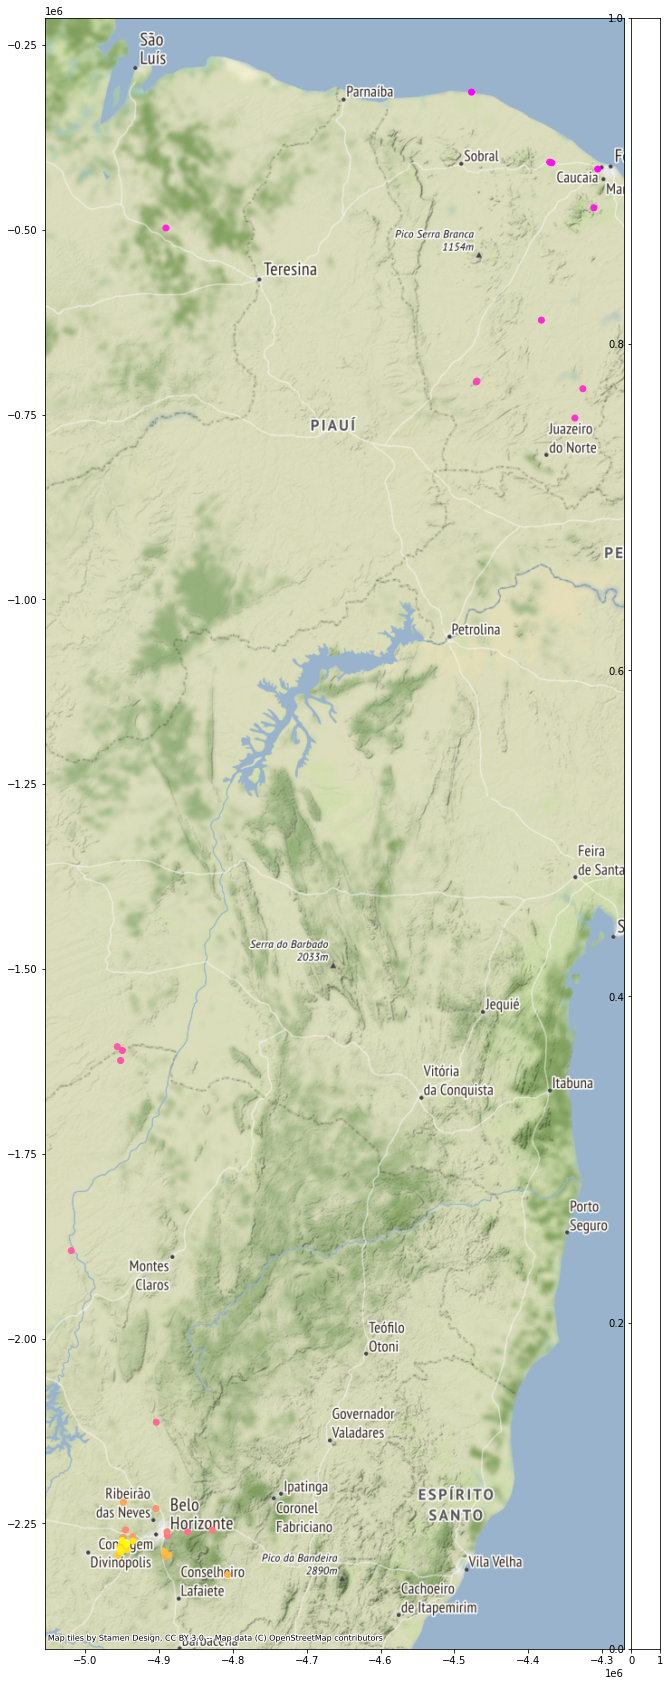

In [42]:
# Conditions plot:
idcond = stationsall.loc[r2listdf.T.loc[:, r2listdf.T.gt(0.95).any()].columns.to_list()].index.tolist()
stationscond = stationsused.loc[idcond]
plot_conditions(stationscond)

Those are the gauges with R² below 0.10:

In [43]:
len(r2listdf.T.loc[:, r2listdf.T.lt(0.1).any()].columns.to_list())

16

In [44]:
stationsall.loc[r2listdf.T.loc[:, r2listdf.T.lt(0.1).any()].columns.to_list()]

Longitude  Latitude              State                 City  \
Code                                                                    
00061000   -61.7858   -0.5067            RORAIMA         RORAINÓPOLIS   
00165000   -65.5906   -1.8611           AMAZONAS                MARAÃ   
00169000   -69.4283   -1.3947           AMAZONAS               JAPURÁ   
00265000   -65.1167   -2.3500           AMAZONAS                MARAÃ   
00268000   -68.7986   -2.8806           AMAZONAS  SANTO ANTÔNIO DO IÇ   
00359001   -59.0897   -3.8847           AMAZONAS  NOVA OLINDA DO NORT   
00362002   -62.6786   -3.4183           AMAZONAS              CODAJÁS   
00567001   -67.8569   -5.8936           AMAZONAS             CARAUARI   
00572000   -72.8136   -5.1375           AMAZONAS     ATALAIA DO NORTE   
03057002   -57.5533  -30.2133  RIO GRANDE DO SUL      BARRA DO QUARAÍ   
08068000   -68.5406    0.1314           AMAZONAS  SÃO GABRIEL DA CACH   
08161001   -61.1236    1.8214            RORAIMA            CARACARAÍ   
08166000   -66.8522    1.2147           AMAZONAS  SÃO GABRIEL DA CACH   
08168000   -68.1536    1.3889           AMAZONAS  SÃO GABRIEL DA CACH   
08360000   -60.5289    4.1667            RORAIMA            PACARAIMA   
08360002   -60.5711    3.2078            RORAIMA            BOA VISTA   

                           Name  
Code                             
00061000  SANTA MARIA DO BOIAÇU  
00165000                  MARAÃ  
00169000       VILA BITTENCOURT  
00265000              SÃO PEDRO  
00268000              BOA UNIÃO  
00359001   NOVA OLINDA DO NORTE  
00362002                BADAJÓS  
00567001                 XIBAUA  
00572000    PALMEIRAS DO JAVARI  
03057002        BARRA DO QUARAÍ  
08068000                TARAQUÁ  
08161001              CARACARAÍ  
08166000                  CUCUÍ  
08168000                  TUNUI  
08360000       MALOCA DO CONTÃO  
08360002       FAZENDA PASSARÃO

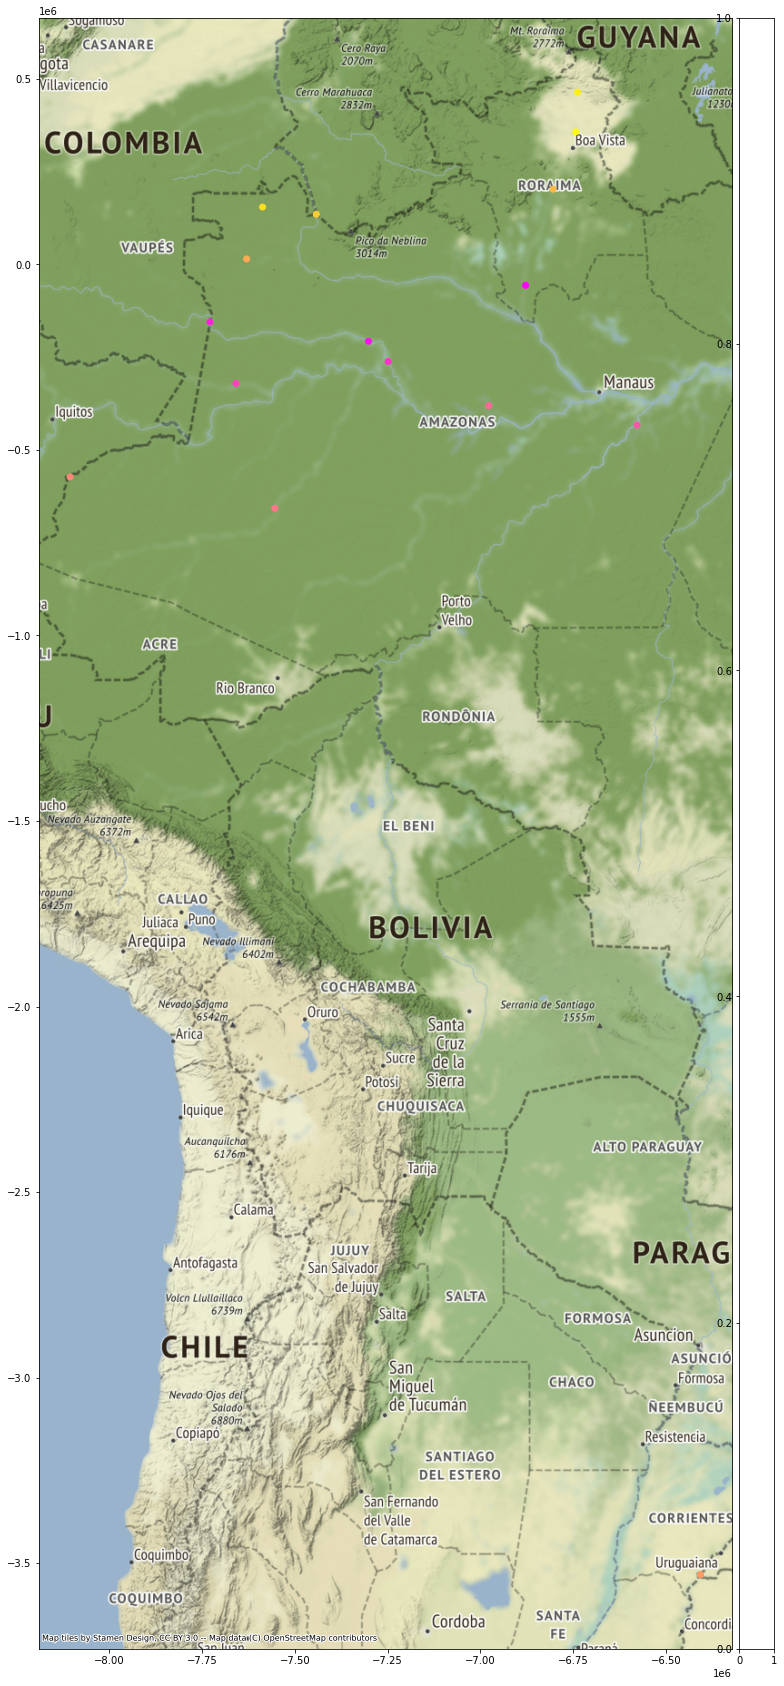

In [45]:
# Conditions plot:
idcond = stationsall.loc[r2listdf.T.loc[:, r2listdf.T.lt(0.1).any()].columns.to_list()].index.tolist()
stationscond = stationsused.loc[idcond]
plot_conditions(stationscond)

<AxesSubplot:xlabel='dates'>

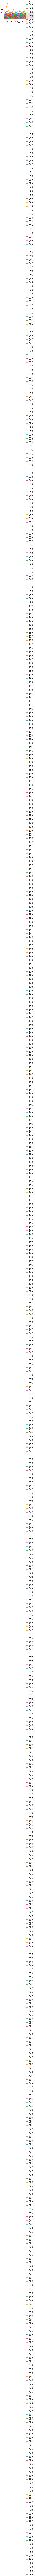

In [46]:
filleddataannual = filleddata.resample('Y').agg(lambda x: np.nan if np.isnan(x).any() else np.sum(x))
filleddataannual.plot()

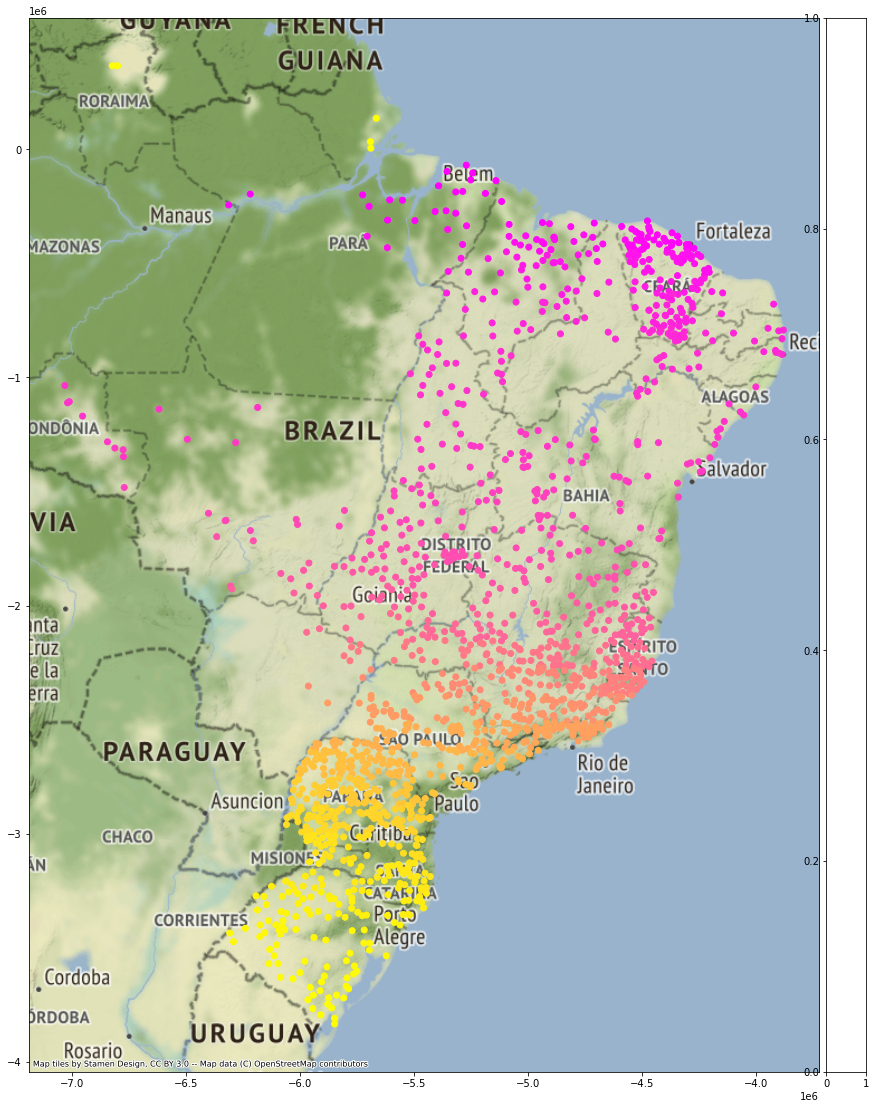

In [48]:
# Conditions plot:
idcond = stationsused.loc[r2listdf.T.loc[:, r2listdf.T.gt(0.8).any()].columns.to_list()].index.tolist()
stationscond = stationsused.loc[idcond]
plot_conditions(stationscond)

In [49]:
filleddata.to_csv(r'C:\Users\User\OneDrive\Projects\Y2022\SPI\cooperacao_raul_e_Thiago\datasets\gauges\filleddata.csv')  

Now we can proceed with the stations that did not managed to be filled before. For them we fill with filled data. 

In [50]:
filleddata2, r2listdf2  = fillinggapsts.fillgapslr(filleddata, stationsused, filtaux, work_w_filter = True, Use_t = True
                                                 , nummaxcorrec = 30)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.32it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.42it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.63it/s]
0it [00:00, ?it/s]
100%|████████████████████

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [0

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.93it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [0

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 19.86it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.78it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.19it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.32it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [0

In [52]:
filleddata2.isnull().values.any()

False

<AxesSubplot:>

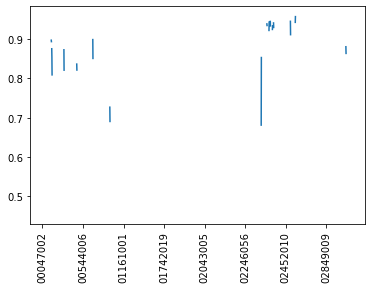

In [53]:
(r2listdf2.Mean**(1/2)).plot(rot=90)

In [61]:
stationsall.loc[r2listdf2.T.loc[:, r2listdf2.T.lt(0.2).any()].columns.to_list()]

Empty DataFrame
Columns: [Longitude, Latitude, State, City, Name]
Index: []